## Экономика преступления и наказания

# Baseline model

### Загрузка и просмотр данных

Данные взяты из открытого досутпа с сайтов Росстат и crimestat <br/> Выполнена предварительная обработка данных (парсинг, приведение данных к информативным показателям). 
* **Преступность** - были получены данные, соответствующие кол-ву зарегестрированных преступлений в регионах России за 10 лет. Для того, чтобы оценить полученную выборку, она была приведена к доле преступлений на число населения, зарегестрированного в регионе на текущий год.
* **Средняя зарплата** - описана в тысячах. Предварительно данные получены в проценте прироста среднего заработка в регионе по сравнению к предыдущему году. Так как такие данные не несут информативности при сравнении уровня жизни в разных регионах, был проведен пересчет в тысячи рублей.
* **Безработица** - данные используются в том виде, в котором изначально были получены

In [187]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split, cross_val_score, KFold

%pylab inline
sns.set()

Populating the interactive namespace from numpy and matplotlib


Загрузка данных

In [188]:
data_fr = pd.read_csv("data_final.csv", sep=';', index_col=[0, 1], decimal=",")

In [189]:
data_fr.rename(columns={"unemployee": "unemployment"}, inplace=True)

In [190]:
data_fr.head(5)

criminality   salary  unemployment
region_name    year                                    
Алтайский край 2010     1.980849  12050.7      4.560774
               2011     1.862957  13822.6      4.278832
               2012     1.752067  16009.7      3.095519
               2013     1.880157  18011.3      4.000094
               2014     1.846779  19456.0      3.492446

Посмотрим, нет ли аномалий в наших признаках

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Mean criminality: 1.5400051536536594


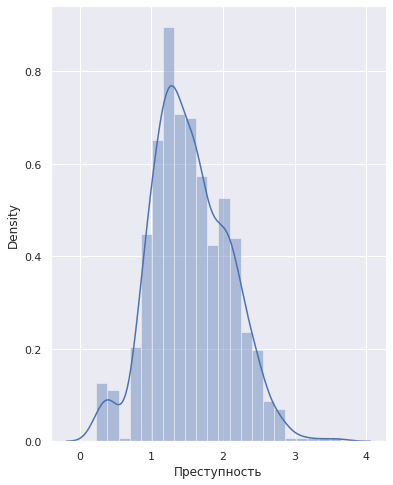

In [191]:
plt.figure(figsize=(6, 8))
sns.distplot(data_fr.criminality)
plt.xlabel('Преступность')
print('Mean criminality:', data_fr.criminality.mean())

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Mean criminality: 29186.401463414615


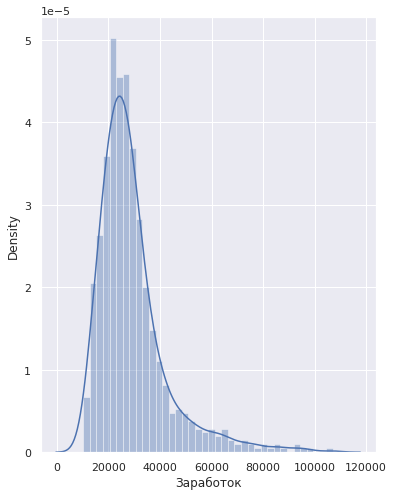

In [192]:
plt.figure(figsize=(6, 8))
sns.distplot(data_fr.salary)
plt.xlabel('Заработок')
print('Mean criminality:', data_fr.salary.mean())

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Mean criminality: 3.604013026384147


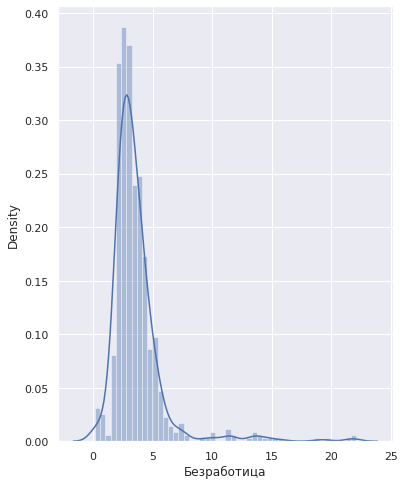

In [193]:
plt.figure(figsize=(6, 8))
sns.distplot(data_fr.unemployment)
plt.xlabel('Безработица')
print('Mean criminality:', data_fr.unemployment.mean())

In [194]:
# нормировка признаков
normalizer = preprocessing.StandardScaler()
data_fr_normalizer = normalizer.fit_transform(data_fr.drop(columns='criminality'))

In [195]:
df_normalized = pd.DataFrame(data_fr_normalizer, columns=data_fr.columns[1:], index=data_fr.index)
df_normalized['criminality'] = data_fr['criminality']
df_normalized.head()

salary  unemployment  criminality
region_name    year                                     
Алтайский край 2010 -1.266560      0.412598     1.980849
               2011 -1.135593      0.291012     1.862957
               2012 -0.973936     -0.219286     1.752067
               2013 -0.825991      0.170808     1.880157
               2014 -0.719208     -0.048113     1.846779

In [196]:
df_normalized.corr()

,salary,unemployment,criminality
salary,1.000000,-0.173085,0.117970
unemployment,-0.173085,1.000000,-0.099194
criminality,0.117970,-0.099194,1.000000


Можно заметить слабую корреляцию данных, наврядли мы сможем получить что-нибудь хорошее из них

### Линейная регрессия (версия 1)

Обучение модели. Разбиваем на обучающую и тренировочную, настраиваем параметры
Смотрим на валидации, что с переобучением

In [197]:
# разбиваем выборку на независимые переменные и целевую
Y_data = df_normalized.criminality
X_data = df_normalized[['unemployment', 'salary']]

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=16)

In [198]:
model_regr = LinearRegression()
model_regr.fit(X_train, y_train)
y_test_pred = model_regr.predict(X_test)

In [199]:
print("Test R2: ", r2_score(y_test, y_test_pred))
print('Model intercept: ', model_regr.intercept_)
print('Model coefficients: ', model_regr.coef_)
print('MSE: ', mean_squared_error(y_test, y_test_pred))

Test R2:  0.006382177684828516
Model intercept:  1.5341167621775644
Model coefficients:  [-0.04051499  0.06298506]
MSE:  0.3234543565603386


По нашей метрике R2 нельзя сказать, что модель является адекватной, но это ожидаемо при отсутствии корреляции между нашими данными

<Figure size 432x432 with 0 Axes>

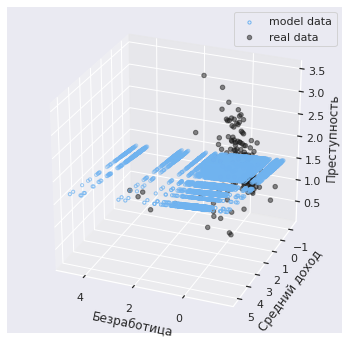

In [200]:
# построим и глянем, что у нас получилось

xx, yy =  np.meshgrid(X_test['unemployment'].values, X_test['salary'].values)
model_viz = np.array([xx.flatten(), yy.flatten()]).T

y_test_pred_vis = model_regr.predict(model_viz)

##########################################################################


plt.figure(figsize(6, 6))
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(xs=xx.flatten(), ys=yy.flatten(), label='model data',
           zs=y_test_pred_vis, facecolor=(0,0,0,0), s=10, edgecolor='#70b3f0')

ax.scatter(xs=X_test['unemployment'], ys=X_test['salary'], zs=y_test, 
           color='k', zorder=15, marker='o', alpha=0.5, label='real data')

ax.locator_params(nbins=4, axis='x')
ax.locator_params(nbins=5, axis='x')

ax.set_xlabel('Безработица')
ax.set_ylabel('Средний доход')
ax.set_zlabel('Преступность')
ax.legend()

ax.view_init(elev=27, azim=112)


В целом, что и показывает нам наша метрика R2. Описать мы смогли нашу модель не очень хорошо, очень малая часть дисперсии нами описана

In [201]:
# проверим на переобучение
kfold = KFold(n_splits=10, random_state=16)
cross_val_score_train = cross_val_score(model_regr, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
print('array MSE: ', cross_val_score_train)
print('test MSE: ', mean_squared_error(y_test, y_test_pred))
print('test MSE mean: ', cross_val_score_train.mean())

array MSE:  [-0.36971251 -0.26719714 -0.24479102 -0.26230501 -0.25870989 -0.23070087
 -0.24064463 -0.31280572 -0.28603814 -0.26007998]
test MSE:  0.3234543565603386
test MSE mean:  -0.27329849019787245


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



Все хорошо, мы не переобучились, ошибка на наших данных больше, чем на валидационной выборке. Хотя в целом, с трудом верится, что на этой модели было реально переобучиться)

Посмотрим, как вообще распределена наша ошибка. Покажем, что она не похожа на нормальную

In [202]:
D_fr_distr = df_normalized.reset_index()
X_train_distr = D_fr_distr[D_fr_distr.year != 2019][['unemployment', 'unemployment']]
X_test_distr = D_fr_distr[D_fr_distr.year == 2019][['unemployment', 'unemployment']]

Y_train_distr = D_fr_distr[D_fr_distr.year != 2019]['salary']
Y_test_distr = D_fr_distr[D_fr_distr.year == 2019]['salary']

model_regr_distr = LinearRegression()
model_regr_distr.fit(X_train_distr, Y_train_distr)
y_test_pred_distr = model_regr_distr.predict(X_test_distr)

Text(0.5, 0, 'распределение ошибки')

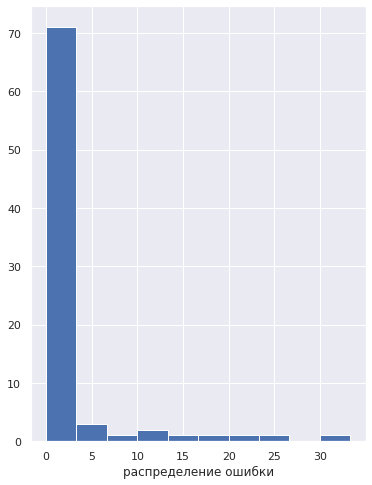

In [203]:
model_error =(Y_test_distr - y_test_pred_distr)**2

plt.figure(figsize=(6, 8))
plt.hist(model_error)
plt.xlabel('распределение ошибки')

Посмотрим зависимость уровня преступности от среднего дохода
и зависимость преступности от безработицы в регионах России за 10 лет

In [204]:
visual_arr = np.vstack((X_test.salary.values, y_test_pred)).T
visual_arr_sort = visual_arr[np.lexsort(np.fliplr(visual_arr).T)]

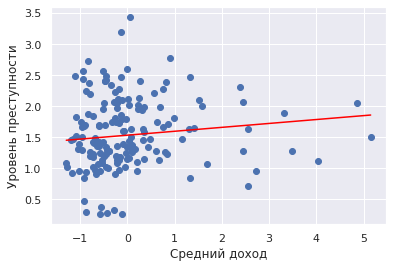

In [205]:
plt.figure(figsize(6, 4))
plt.scatter(X_test.salary, y_test)

model_y = model_regr.intercept_ + model_regr.coef_[1] * visual_arr_sort[:, 0]
plt.plot(visual_arr_sort[:, 0], model_y, c='red')

plt.xlabel('Средний доход')
plt.ylabel('Уровень преступности')
plt.show()

Ну здесь в целом все понятно. У нас есть города, где доход маленький, а его рост соответсвует малому доходу в других регинах (например Москве)

In [206]:
visual_arr = np.vstack((X_test.unemployment.values, y_test_pred)).T
visual_arr_sort = visual_arr[np.lexsort(np.fliplr(visual_arr).T)]

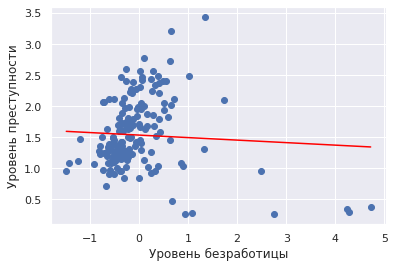

In [207]:
plt.figure(figsize(6,4))
plt.scatter(X_test.unemployment, y_test)

model_y = model_regr.intercept_ + model_regr.coef_[0] * visual_arr_sort[:, 0]
plt.plot(visual_arr_sort[:, 0], model_y, c='red')

plt.xlabel('Уровень безработицы')
plt.ylabel('Уровень преступности')
plt.show()

Здесь все бы ничего, но у нас жуткие аномалии есть. Скорее всего они связаны с экономическим кризисом в стране. Если пофильтровать наши данные, то скорее всего станет получше

### Вывод по модели 1

Беккер утверждает, что изначальный уровень среднего заработка и безработица влияют на фактор образования преступности.

* Текущие данные имеют высокую дисперсию. На основе текущей информации трудно о чем-то согласиться с Беккером, несмотря на его авторитет)

* Средний заработок на текущий момент не несет информативности.
Это связано с тем, что в разных регионах средний заработок существенно отличается.

* Безработица тоже не несет полезной информации, там имеются в целом аномальные выбросы. Скорее всего они связаны с экономическим кризисом в стране.

* Наши показатели по модели:
1.   Test R2:  0.006382177684828516
2.   MSE:  0.3234543565603386


### Линейная регрессия (2 версия)

А теперь попробуем настроить нашу модель с точки зрения того, что мы имеем дело с временным рядом. Здесь выполним прогнозирование по России.

In [208]:
# сгруппируем наши данные по годам и усредним нашу выборку по регионам
X_data_year = pd.pivot_table(df_normalized, values=['unemployment', 'salary', 'criminality'], index=['year'],
                               aggfunc=mean).reset_index()

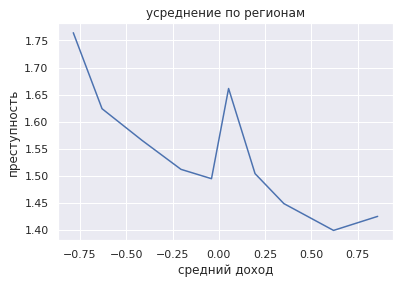

In [209]:
plt.figure(figsize(6,4 ))
plt.plot(X_data_year.salary, X_data_year.criminality)
plt.xlabel('средний доход')
plt.ylabel('преступность')
plt.title('усреднение по регионам')
plt.show()

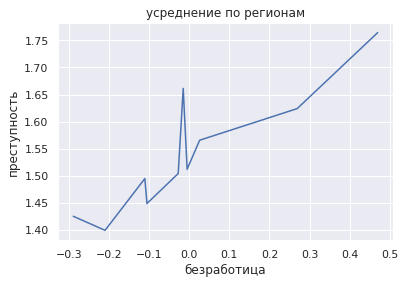

In [210]:
visual_arr = np.vstack((X_data_year.unemployment.values, X_data_year.criminality)).T
visual_arr_sort = visual_arr[np.lexsort(np.fliplr(visual_arr).T)]

plt.figure(figsize(6,4 ))
plt.plot(visual_arr_sort[:, 0], visual_arr_sort[:, 1])
plt.xlabel('безработица')
plt.ylabel('преступность')
plt.title('усреднение по регионам')
plt.show()

In [211]:
X_data_year[['criminality', 'salary', 'unemployment']].corr()

,criminality,salary,unemployment
criminality,1.000000,-0.826781,0.894527
salary,-0.826781,1.000000,-0.911747
unemployment,0.894527,-0.911747,1.000000


Видим, что преступность уменьшается при увеличении среднего дохода и уменьшении безработицы. Возможно Беккер прав

Обучение модели

In [212]:
# валидация

# разбиваем выборку на независимые переменные и целевую
y_train = X_data_year['criminality'].head(9)
X_train = X_data_year[['salary', 'unemployment']].head(9)

tscv = TimeSeriesSplit(max_train_size = None, n_splits = 5)

model_regr = LinearRegression()
cv_scores = cross_val_score(model_regr, X_train, y_train, cv=tscv,
                                 scoring = 'neg_mean_squared_error')
  
print("Test MSE: ", mean(cv_scores))

Test MSE:  -0.011273546492685608


In [214]:
# обучим модель

# разбиваем выборку на независимые переменные и целевую
y_train = X_data_year['criminality'].head(9)
X_train = X_data_year[['salary', 'unemployment']].head(9)

y_test = X_data_year['criminality'].tail(1)
X_test = X_data_year[['salary', 'unemployment']].tail(1)

model_regr = LinearRegression()

model_regr.fit(X_train, y_train)
y_test_pred = model_regr.predict(X_test)

print("Test MSE: ", mean_squared_error(y_test, y_test_pred))

Test MSE:  0.0013807387138489505


Посмотрим, что же прогнозирует наш временной ряд в данном случае

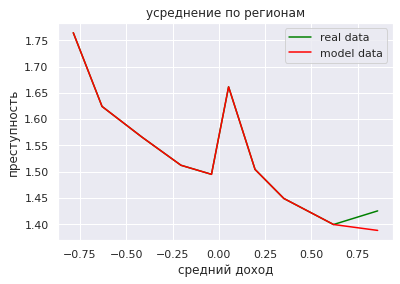

In [215]:
Y_pred = np.concatenate((y_train, y_test_pred), axis=0)

plt.figure(figsize(6,4 ))
plt.plot(X_data_year['salary'], X_data_year['criminality'], label='real data', c = 'green')
plt.plot(X_data_year['salary'], Y_pred, c = 'red', label='model data')
plt.xlabel('средний доход')
plt.ylabel('преступность')
plt.title('усреднение по регионам')
plt.legend()
plt.show()

Пожалуй оставим так. Как можно увидеть, если рассматривать выборку, как временной ряд, то модель ведет себя адекватнее

### Вывод по модели 2

* В целом Беккер прав. На основе текущей модели с ним можно согласиться.

* Рост среднего заработка действительно связан со спадом перступности. 

* В случае уменьшения безработницы преступность тоже уменьшается.

* Наши показатели по модели:
1.   Test MSE:  -0.011273546492685608


# User model

Теперь попроубем сделать нашу модель лучше

### Загрузка и просмотр данных

Добавим в нашу модель новые данные:
* ***Прожиточный минимум*** - процент населения, прожиточный минимум которых ниже установленного.
* ***Процент раскрытых преступлений***  - можно оценить вероятность того, что человек решится на преступление.
* Попытаемся понять характер аномалий в выборке безработицы и исключить их в случае малой информативности.

In [216]:
data_fr_user = pd.read_csv("data_final_user.csv", sep=';', index_col=[0, 1], decimal=",")

In [217]:
data_fr_user.rename(columns={"unemployee": "unemployment"}, inplace=True)

In [218]:
data_fr_user.head(5)

criminality   salary  unemployment  catch_crimes  minimum
region_name    year                                                           
Алтайский край 2010     1.980849  12050.7      4.560774     55.507424    17.57
               2011     1.862957  13822.6      4.278832     56.223854    17.57
               2012     1.752067  16009.7      3.095519     56.904660    17.57
               2013     1.880157  18011.3      4.000094     55.132818    17.60
               2014     1.846779  19456.0      3.492446     56.157021    17.10

Посмотрим на распределение новых данных

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Mean minimum: 14.612902439024372


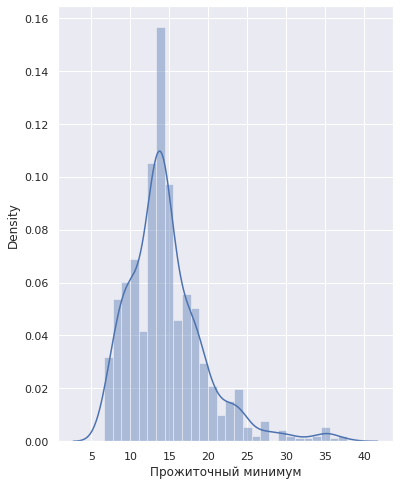

In [219]:
plt.figure(figsize=(6, 8))
sns.distplot(data_fr_user.minimum)
plt.xlabel('Прожиточный минимум')
print('Mean minimum:', data_fr_user.minimum.mean())

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Mean minimum: 49.300173942707374


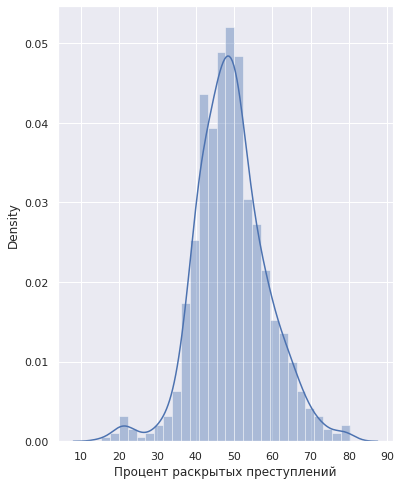

In [220]:
plt.figure(figsize=(6, 8))
sns.distplot(data_fr_user.catch_crimes)
plt.xlabel('Процент раскрытых преступлений')
print('Mean minimum:', data_fr_user.catch_crimes.mean())

Теперь проанализируем, почему у нас высокая безработица и низкая преступность имеет аномальное явление

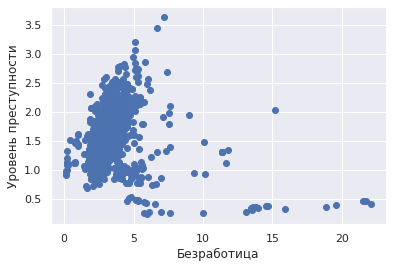

In [221]:
plt.figure(figsize(6, 4))
plt.scatter(data_fr_user.unemployment, data_fr_user.criminality)

plt.xlabel('Безработица')
plt.ylabel('Уровень преступности')
plt.show()

In [222]:
data_fr_user[['unemployment', 'criminality']].sort_values(by=['unemployment', 'criminality'], ascending=False).head(15)

unemployment  criminality
region_name          year                           
Республика Ингушетия 2012     22.065018     0.410199
                     2011     21.752673     0.457505
                     2010     21.546781     0.466198
                     2013     19.595114     0.390723
Чеченская Республика 2010     18.876202     0.362850
                     2011     15.928976     0.330116
г. Севастополь       2015     15.188485     2.030332
Республика Ингушетия 2016     14.654319     0.375558
                     2015     14.551581     0.368967
                     2017     13.952864     0.331641
                     2014     13.777699     0.354018
                     2019     13.572376     0.358404
Чеченская Республика 2012     13.543632     0.298371
Республика Ингушетия 2018     13.450114     0.335893
Чеченская Республика 2013     13.082041     0.272237

Как мы видим, выбросами являются 2 республики, коррелирующие между собой в системе управления и религии. Попробуем исключить их из нашей выборки. Еще там находится Севастополь, данные о городе отсутствуют отсутствуют в открытом доступе до 2015 года

In [223]:
data_fr_user_correct = data_fr_user.drop(index=['Чеченская Республика', 'Республика Ингушетия', 'г. Севастополь'], level=0)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Mean minimum: 3.2516095890113905


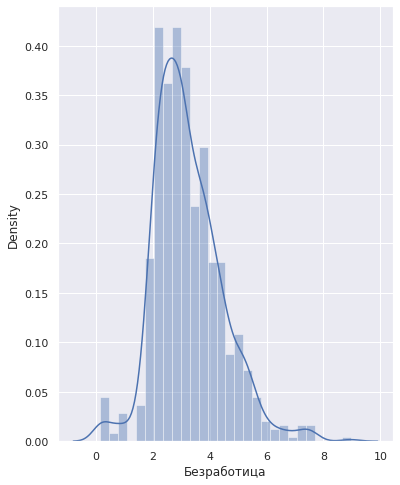

In [224]:
plt.figure(figsize=(6, 8))
sns.distplot(data_fr_user_correct.unemployment)
plt.xlabel('Безработица')
print('Mean minimum:', data_fr_user_correct.unemployment.mean())

Избавились от аномалий, посмотрим, сможет ли это улучшить предиктивность нашей модели

In [225]:
# нормировка признаков
normalizer = preprocessing.StandardScaler()
data_fr_normalizer = normalizer.fit_transform(data_fr_user_correct.drop(columns='criminality'))

In [226]:
df_user_norm = pd.DataFrame(data_fr_normalizer, columns=data_fr_user_correct.columns[1:], index=data_fr_user_correct.index)
df_user_norm['criminality'] = data_fr_user_correct['criminality']
df_user_norm.head()

salary  unemployment  ...   minimum  criminality
region_name    year                          ...                       
Алтайский край 2010 -1.268369      1.094306  ...  0.581758     1.980849
               2011 -1.137396      0.858635  ...  0.581758     1.862957
               2012 -0.975732     -0.130474  ...  0.581758     1.752067
               2013 -0.827780      0.625644  ...  0.587713     1.880157
               2014 -0.720992      0.201310  ...  0.488464     1.846779

[5 rows x 5 columns]

In [227]:
df_user_norm.corr()

,salary,unemployment,catch_crimes,minimum,criminality
salary,1.000000,-0.276817,0.000648,-0.199600,0.101776
unemployment,-0.276817,1.000000,0.306041,0.626470,0.331733
catch_crimes,0.000648,0.306041,1.000000,0.286819,-0.197853
minimum,-0.199600,0.626470,0.286819,1.000000,0.181584
criminality,0.101776,0.331733,-0.197853,0.181584,1.000000


* Прожиточный минимум имеет корреляцию с безработицей, интересный факт. Скорее всего это связано с увеличением количества людей, живущих на пособии
* В целом, сейчас корреляция между нашими независимыми переменными и целевой стала существеннее


In [228]:
# сгруппируем наши данные по годам и усредним нашу выборку по регионам
X_data_year = pd.pivot_table(df_user_norm, values=['unemployment', 'salary', 'criminality', 'catch_crimes', 'minimum'], index=['year'],
                               aggfunc=mean).reset_index()

In [229]:
X_data_year.drop(columns='year').corr()

,catch_crimes,criminality,minimum,salary,unemployment
catch_crimes,1.000000,-0.587780,-0.022736,0.349016,-0.522331
criminality,-0.587780,1.000000,0.210459,-0.828401,0.892549
minimum,-0.022736,0.210459,1.000000,0.122051,0.113712
salary,0.349016,-0.828401,0.122051,1.000000,-0.872252
unemployment,-0.522331,0.892549,0.113712,-0.872252,1.000000


Посмотрим на наши временные ряды в зависимости от преступности по каждой из фичей

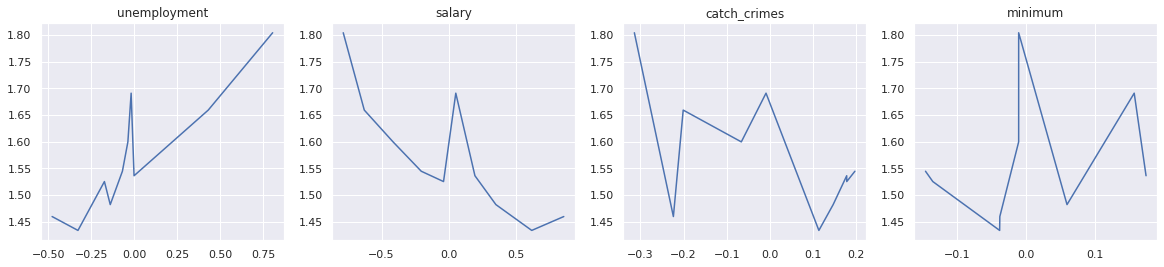

In [230]:
plt.figure(figsize=(20, 4))  

idx = ['unemployment', 'salary', 'catch_crimes', 'minimum']
count = 0

for i in idx:
    
    visual_arr = np.vstack((X_data_year[i].values, X_data_year['criminality'].values)).T
    visual_arr_sort = visual_arr[np.lexsort(np.fliplr(visual_arr).T)] 

    plt.subplot(1, 4, count+1)
    count += 1

    plt.plot(visual_arr_sort[:, 0], visual_arr_sort[:, 1])
    plt.title(i)

### Вывод
* Теория Беккера действительно работает, это хорошо видно на графиках выше
* Безработица ведет к повышению преступности. Увеличение процента населения с доходом ниже прожиточного минимума в регионах не дает ясной картины влияния на преступность. Присутствует слабая корреляционная зависимость
* Увеличение среднего дохода уменьшает уровень преступности. Также положительно для нас, то есть, уменьшая уровень преступности, влияет вероятность быть пойманным

### Регрессионная модель по всей выборке

Обучение модели. Разбиваем на обучающую и тренировочную, настраиваем параметры
Смотрим на валидации, что с переобучением

In [231]:
# разбиваем выборку на независимые переменные и целевую
Y_data = df_user_norm.criminality
X_data = df_user_norm.drop(columns= 'criminality')

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=16)

In [232]:
model_regr = LinearRegression()
model_regr.fit(X_train, y_train)
y_test_pred = model_regr.predict(X_test)

In [233]:
print('Model intercept: ', model_regr.intercept_)
print('Model coefficients: ', model_regr.coef_)
print('MSE: ', mean_squared_error(y_test, y_test_pred))
print("Test R2: ", r2_score(y_test, y_test_pred))

Model intercept:  1.5709865628790025
Model coefficients:  [ 0.1146681   0.25426358 -0.18144908  0.01033295]
MSE:  0.17278776007764826
Test R2:  0.28303101224330063


In [234]:
# проверим на переобучение
kfold = KFold(n_splits=10, random_state=16)
cross_val_score_train = cross_val_score(model_regr, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
print('array MSE: ', cross_val_score_train)
print('my MSE: ', mean_squared_error(y_test, y_test_pred))
print('test MSE mean: ', cross_val_score_train.mean())

array MSE:  [-0.14892506 -0.23657908 -0.27378549 -0.16199101 -0.15459093 -0.21440991
 -0.22569334 -0.174259   -0.17392036 -0.2085939 ]
my MSE:  0.17278776007764826
test MSE mean:  -0.1972748081914837


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



Все хорошо, оставим так

### Вывод по модели:
* Модификация наших данных позволила нам получить более хорошую модель. Мы получили улучшение по показателям MSE и R2
* Параметры модели:
1.   MSE:  0.17278776007764826
2.   Test R2:  0.28303101224330063

### Временные ряды

Посмотрим, что выдаст наша модель, если мы будем рассматривать ее, как временной ряд. Агрегируем наши данные для прогнозирования по России

***Прогнозирование по России***. Обучение модели

In [235]:
# сгруппируем наши данные по годам и усредним нашу выборку по регионам
X_data_year = pd.pivot_table(df_user_norm, values=['unemployment', 'salary', 'criminality', 'catch_crimes', 'minimum'], index=['year'],
                               aggfunc=mean).reset_index()

In [125]:
X_data_year.drop(columns='year').corr()

,catch_crimes,criminality,minimum,salary,unemployment
catch_crimes,1.000000,-0.587780,-0.022736,0.349016,-0.522331
criminality,-0.587780,1.000000,0.210459,-0.828401,0.892549
minimum,-0.022736,0.210459,1.000000,0.122051,0.113712
salary,0.349016,-0.828401,0.122051,1.000000,-0.872252
unemployment,-0.522331,0.892549,0.113712,-0.872252,1.000000


Уберем процент людей, у которых доход ниже прожиточного минимума. Информации по итогу в фиче нет

In [236]:
# валидация

# разбиваем выборку на независимые переменные и целевую
y_train = X_data_year.criminality.head(9)
X_train = X_data_year.drop(columns= ['criminality', 'year', 'minimum']).head(9)

tscv = TimeSeriesSplit(max_train_size = None, n_splits = 8)

model_regr = LinearRegression()
cv_scores = cross_val_score(model_regr, X_train, y_train, cv=tscv,
                                 scoring = 'neg_mean_squared_error')

print("cv MSE:", cv_scores)  
print("Test MSE: ", mean(cv_scores) )


cv MSE: [-0.02102319 -0.01514491 -0.18310301 -0.65351288 -0.01021774 -0.01308814
 -0.0135248  -0.01173204]
Test MSE:  -0.11516833911543173


In [237]:
# обучим модель

# разбиваем выборку на независимые переменные и целевую
y_train = X_data_year.criminality.head(9)
X_train = X_data_year.drop(columns= ['criminality', 'year', 'minimum']).head(9)

y_test = X_data_year.criminality.tail(1)
X_test = X_data_year.drop(columns= ['criminality', 'year', 'minimum']).tail(1)

model_regr = LinearRegression()

model_regr.fit(X_train, y_train)
y_test_pred = model_regr.predict(X_test)

print("Test MSE: ", mean_squared_error(y_test, y_test_pred))

Test MSE:  0.0022762260919260402


Посмотрим, что же прогнозирует наш временной ряд в данном случае

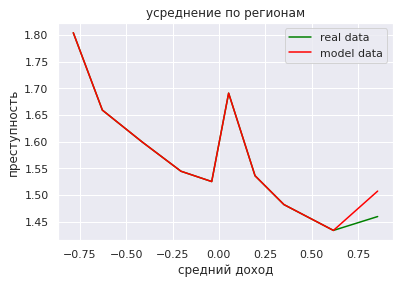

In [238]:
Y_pred = np.concatenate((y_train, y_test_pred), axis=0)

plt.figure(figsize(6,4 ))
plt.plot(X_data_year['salary'], X_data_year['criminality'], label='real data', c = 'green')
plt.plot(X_data_year['salary'], Y_pred, c = 'red', label='model data')
plt.xlabel('средний доход')
plt.ylabel('преступность')
plt.title('усреднение по регионам')
plt.legend()
plt.show()

В целом при такой разнице MSE при прогнозировании ВР сложно сказать, переобучились ли мы. Для этого строим ВР - как можно заметить, для прогноза на 1 шаг вперед модель ведет себя адекватно

In [241]:
print('Model intercept: ', model_regr.intercept_)
print('Model coefficients: ', model_regr.coef_)
print('y_real:', y_test.values, 'y_model:', y_test_pred)

Model intercept:  1.578266945112342
Model coefficients:  [-0.19390924 -0.05625839  0.1384671 ]
y_real: [1.45963052] y_model: [1.50734033]


### Вывод

* Наша модель обучилась предсказывать уровень преступности на основе независимых данных
* В качестве модели используется временной ряд
* Для проверки на переобучение используется валидация модели
* Результаты модели для прогноза по России:
1. Test MSE:  0.0022762260919260402
2. y_real: [1.45963052] y_model: [1.50734033]
